In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# 02: Base Model
Train a model.  Keep the model fairly small to make this script, and future ones which use computationally intensive methods like SHAP, feasible to run on home hardware.

Due to compatibility with sklearn_gbmi, I am using a GradientBoostingClassifier model.  This model is slow-ish and does not seem as accurate as, say, xgboost.  However, since I am interested in interactions, this is OK.

*This script takes about 15 minutes to run on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path

In [3]:
import sklearn as sk
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
    average_precision_score, roc_auc_score
from sklearn.inspection import permutation_importance
from scikitplot.metrics import plot_lift_curve
from sklearn.ensemble import GradientBoostingClassifier

In [4]:
from interactions_package.interactions_package import ip_plot
ip_plot.plot_defaults()

## Import Processed Datasets

In [5]:
train_df = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_combined_base_train.parquet'))

In [6]:
test_df = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_combined_base_test.parquet'))

In [7]:
val_df = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_combined_base_val.parquet'))

##### Get predictors

In [8]:
predictor_features = pd.read_csv(Path(setup.temp_path) \
                                 .joinpath('01_REPORT_predictor_features.csv'))['feature'].tolist()

In [9]:
len(set(predictor_features))

18

## Model Hyperparameter Tune and Fit

In [10]:
mean_target = np.mean(train_df['target'])
mean_target

0.19962582237312326

##### Do a simple hyperparameter search

In [11]:
base_model = GradientBoostingClassifier(n_estimators = 20)

In [12]:
hyperparam_serarch = {'learning_rate': [0.01, 0.05, 0.1],
                      'min_samples_split': [1, 10, 20],
                      'min_samples_leaf': [1, 5, 20],
                      'max_depth': [4, 5, 6],
                      'max_leaf_nodes': [None, 30, 100]}

In [13]:
# Set up a cross validation without the final fit; don't use early stopping yet
random_search = RandomizedSearchCV(base_model, 
                                   hyperparam_serarch,
                                   n_iter=20, 
                                   n_jobs=-1,
                                   random_state=1055,
                                   verbose = 0,
                                   refit = False)

In [14]:
# Do the cross validation parameter search
rs_fit = random_search.fit(train_df[predictor_features], train_df['target']);

In [15]:
print(random_search.best_params_)

{'min_samples_split': 20, 'min_samples_leaf': 20, 'max_leaf_nodes': None, 'max_depth': 6, 'learning_rate': 0.1}


In [16]:
pd.DataFrame({k:[random_search.best_params_[k]] for k in random_search.best_params_.keys()}) \
    .to_csv(Path(setup.temp_path).joinpath('02_REPORT_selected_features.csv'), index=False)

##### Do a final fit with the full training data

In [17]:
base_model.set_params(**random_search.best_params_)

GradientBoostingClassifier(max_depth=6, min_samples_leaf=20,
                           min_samples_split=20, n_estimators=20)

In [18]:
base_model.fit(train_df[predictor_features], train_df['target'])

GradientBoostingClassifier(max_depth=6, min_samples_leaf=20,
                           min_samples_split=20, n_estimators=20)

##### Save the model

In [19]:
with open(Path(setup.temp_path).joinpath('02_MODEL_base_gc.pkl'), 'wb') as po:
    pickle.dump(base_model, po)

In [20]:
base_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 20,
 'min_samples_split': 20,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 20,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

## Metrics

##### Classification metrics
Accuracy, f1, precision, recall

In [21]:
metrics_class_df = pd.concat([pd.DataFrame({metf.__name__: [metf(df['target'], 
                                                                 base_model.predict(df[predictor_features]))] \
              for metf in [accuracy_score, f1_score, precision_score, recall_score]})
           for df in [train_df, test_df, val_df]], keys = ['train', 'test', 'val']) \
    .reset_index(level=1, drop=True)

##### AUC scores
PR-AUC and ROC-AUC

In [22]:
metrics_auc_df = pd.concat([pd.DataFrame({metf.__name__: [metf(df['target'], 
                                                               base_model.predict_proba(df[predictor_features])[:,1])] \
              for metf in [average_precision_score, roc_auc_score]})
           for df in [train_df, test_df, val_df]], keys = ['train', 'test', 'val']) \
    .reset_index(level=1, drop=True)

In [23]:
metrics_df = pd.concat([metrics_class_df, metrics_auc_df], axis=1)

In [24]:
metrics_df

,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score
train,0.801462,0.028102,0.616859,0.014379,0.377591,0.712000
test,0.801172,0.026136,0.588063,0.013365,0.372586,0.709407
val,0.801406,0.026850,0.615752,0.013724,0.364952,0.702959


This model isn't terribly good.  The target rate is ~20% and so 0.20 is the baseline PR-AUC (average precision score).  So the model is about 1.8 x random.  However I am interested in interactions and want to keep this model simple so this is OK for this purpose

Looking at precision and recall, the max f1 threshold might not be the best decision threshold.  However I am not using a decision threshold and so can ignore this.

## Lift

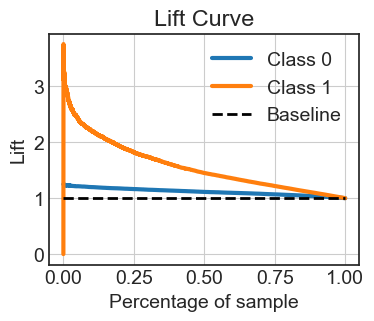

In [25]:
plot_lift_curve(val_df['target'], 
                base_model.predict_proba(val_df[predictor_features]), 
                title='Lift Curve', ax=None, figsize=(4,3), 
                title_fontsize='large', text_fontsize='medium')
plt.gca().legend(loc='upper right')
plt.gcf().savefig(Path(setup.temp_path).joinpath('02_PLOT_lift_curve.png'),
                 bbox_inches='tight')

## Feature Importance 

##### Impurity Importance

In [26]:
feature_importance_df= pd.DataFrame({'feature': predictor_features,
                                    'importance': base_model.feature_importances_}) \
    .sort_values('importance', ascending=False)

In [27]:
feature_importance_df.head(3)

,feature,importance
2,int_rate,0.716283
1,term,0.080824
11,mort_acc,0.033547


In [28]:
feature_importance_df.to_csv(Path(setup.temp_path).joinpath('02_REPORT_importance_impurity.csv'), index=True)

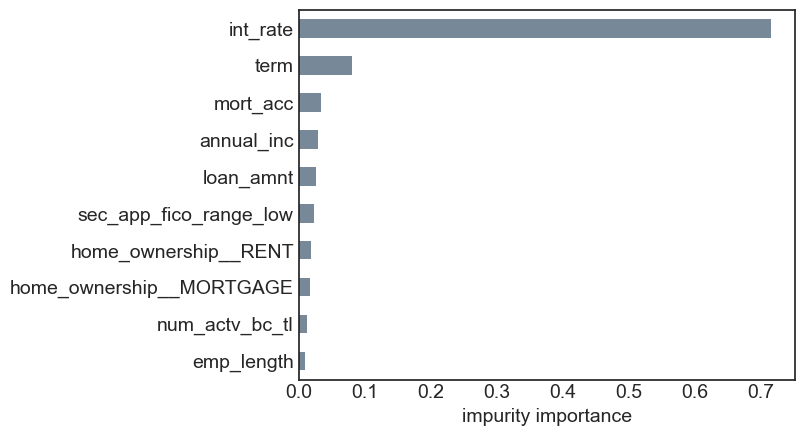

In [29]:
feature_importance_df.head(10).set_index('feature') \
    .plot(kind='barh', legend=None, color='lightslategray')
plt.gca().invert_yaxis()
plt.xlabel('impurity importance')
plt.ylabel(None)
plt.gcf().savefig(Path(setup.temp_path).joinpath('02_PLOT_importance_gain.png'),
                 bbox_inches='tight')

##### Permutation Importance

In [30]:
perm_importance = permutation_importance(base_model, 
                                         train_df[predictor_features], 
                                         train_df['target'])

In [31]:
perm_importance_df = pd.DataFrame({'features':predictor_features,
                                   'importance': perm_importance['importances_mean']}) 
perm_importance_df['abs_importance'] = np.abs(perm_importance_df['importance'])
perm_importance_df = perm_importance_df.sort_values('abs_importance', ascending=False)

In [32]:
perm_importance_df \
    .to_csv(Path(setup.temp_path).joinpath('02_DATA_importance_perturb.csv'),
            index=False)

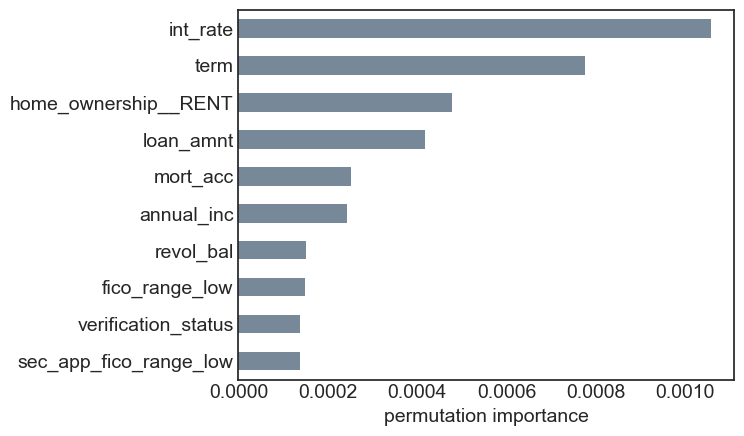

In [33]:
perm_importance_df.head(10) \
    .plot(kind='barh', x='features', y='importance', legend=None, color='lightslategray')
plt.gca().invert_yaxis()
plt.xlabel('permutation importance')
plt.ylabel(None)
plt.gcf().savefig(Path(setup.temp_path).joinpath('02_PLOT_importance_perturb.png'),
                 bbox_inches='tight')

I am not an expert on lending, but it makes sense that the interest rate is the most important feature.  Interest rate should capture financial risk, as opposed to strict default risk. So the interest rate should incorporate information beyond the default rate, such as loan amount.   

Interactions between interest rates and other features might capture the difference between financial and default risks.  Or, interactions could reflect sub-populations for whom the interst rate is not well calibrated.